✔ Figura guardada en: C:\Users\FABIO\Downloads\pca_temporadas_overlay.png
Varianza explicada: PC1=0.168, PC2=0.150, Total=0.318


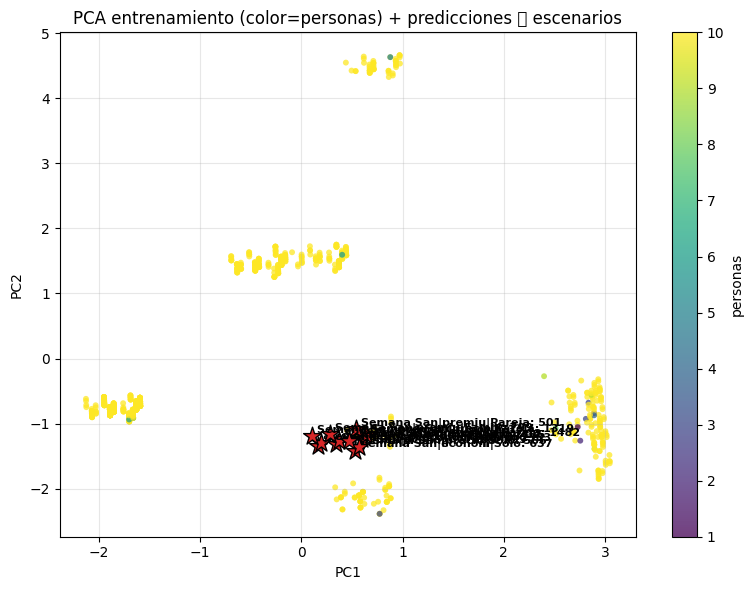

In [8]:
# =========================================
# PCA limpio (regresión) + overlay de predicciones del modelo KNN
# =========================================
# Requisitos: pandas, numpy, matplotlib, scikit-learn, joblib (y pycaret si usaste .pkl)
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import joblib

# ---------- RUTAS (ajusta a tu entorno) ----------
TRAIN_CSV     = Path(r"C:\Users\FABIO\Downloads\temporadas_SEG_TIPO_recalibrado_2020_2024_50k.csv")  # agregado 2020–2024
MODEL_PATH    = Path(r"C:\Users\FABIO\Downloads\modelo_knn_temporadas_personas.joblib")          # tu .joblib
SCENARIO_CSV  = Path(r"C:\Users\FABIO\Downloads\mis_escenarios_2025.csv")                        # opcional
FIG_OUT       = Path(r"C:\Users\FABIO\Downloads\pca_temporadas_overlay.png")

# ---------- CONFIG ----------
SUBSAMPLE_N = 800      # para que el scatter sea legible (None para usar todo)
DPI         = 180
CMAP        = "viridis"  # color por valor de personas

# ---------- LECTURA Y LIMPIEZA ----------
df = pd.read_csv(TRAIN_CSV, encoding="utf-8-sig")
# En tus datasets el target puede llamarse 'personas' o 'personas_total'
TARGET = "personas" if "personas" in df.columns else "personas_total"
if TARGET not in df.columns:
    raise ValueError("No encuentro la columna objetivo (ni 'personas' ni 'personas_total').")

# Unificar rótulos de puentes
if "temporada" in df.columns:
    df["temporada"] = df["temporada"].astype(str).str.replace(r"^Puente festivo.*", "Puente festivo", regex=True)

# ---------- FEATURES ----------
cat_cols = ["temporada","segmento","Tipo_viajero"]
num_cols = ["anio","duracion_dias","mes_inicio","es_evento_ciudad","es_semana_santa","es_navidad","es_puente"]
use_cols = cat_cols + num_cols + [TARGET]
df = df[use_cols].copy()

# One-hot para categóricas
X_cat = pd.get_dummies(df[cat_cols], drop_first=True)
X_num = df[num_cols].apply(pd.to_numeric, errors="coerce")
X_num = X_num.fillna(0.0)

X_full = pd.concat([X_num, X_cat], axis=1)
y = pd.to_numeric(df[TARGET], errors="coerce").fillna(0.0)

# Submuestreo opcional (solo para la visualización)
if SUBSAMPLE_N and SUBSAMPLE_N < len(df):
    idx = np.random.RandomState(42).choice(len(df), size=SUBSAMPLE_N, replace=False)
    X_plot = X_full.iloc[idx].reset_index(drop=True)
    y_plot = y.iloc[idx].reset_index(drop=True)
else:
    X_plot = X_full.copy()
    y_plot = y.copy()

# ---------- PCA (imputación + escalado + proyección) ----------
imp = SimpleImputer(strategy="median").fit(X_full.values)
sc  = StandardScaler().fit(imp.transform(X_full.values))
pca = PCA(n_components=2, random_state=42).fit(sc.transform(imp.transform(X_full.values)))

Z = pca.transform(sc.transform(imp.transform(X_plot.values)))

# ---------- GRAFICAR: fondo coloreado por 'personas' ----------
plt.figure(figsize=(8,6))
p = plt.scatter(Z[:,0], Z[:,1], c=y_plot.values, cmap=CMAP, s=18, alpha=0.75, edgecolors="none")
cb = plt.colorbar(p); cb.set_label(TARGET)

plt.title("PCA del set de entrenamiento (color = personas)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(True, alpha=0.3)

# ---------- OVERLAY (opcional): escenarios + predicción del modelo ----------
stars = []
if SCENARIO_CSV.exists():
    # Cargar modelo
    try:
        model = joblib.load(MODEL_PATH)
        use_pycaret = False
    except Exception:
        try:
            from pycaret.regression import load_model, predict_model
            model = load_model(str(MODEL_PATH).replace(".joblib",""))  # si guardaste con save_model (sin .pkl)
            use_pycaret = True
        except Exception as e:
            raise RuntimeError(f"No pude cargar el modelo: {e}")

    scn = pd.read_csv(SCENARIO_CSV, encoding="utf-8-sig")
    scn["temporada"] = scn["temporada"].astype(str).str.replace(r"^Puente festivo.*", "Puente festivo", regex=True)

    # Alinear columnas de PCA (mismo one-hot)
    Xs_cat = pd.get_dummies(scn[cat_cols], drop_first=True)
    Xs_num = scn[num_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)

    # asegurar mismas columnas que X_full (reindex con fill_value=0)
    Xs_cat = Xs_cat.reindex(columns=X_cat.columns, fill_value=0)
    Xs = pd.concat([Xs_num, Xs_cat], axis=1)

    Zs = pca.transform(sc.transform(imp.transform(Xs.values)))

    # Predicción con el modelo (pipeline completa)
    if not use_pycaret:
        yhat = model.predict(scn)  # el .joblib de PyCaret es una pipeline; acepta DF crudo
    else:
        from pycaret.regression import predict_model
        yhat = predict_model(model, data=scn)["prediction_label"].values

    # Dibujar estrellas
    for i in range(len(scn)):
        plt.scatter(Zs[i,0], Zs[i,1], s=180, marker="*", c="tab:red", edgecolor="k", linewidths=1.0, zorder=3)
        lbl = f"{scn.loc[i,'temporada'][:10]}|{scn.loc[i,'segmento'][:6]}|{scn.loc[i,'Tipo_viajero'][:6]}: {int(round(yhat[i]))}"
        plt.text(Zs[i,0]+0.05, Zs[i,1]+0.05, lbl, fontsize=8, weight="bold")
    plt.title("PCA entrenamiento (color=personas) + predicciones ⭐ escenarios")

plt.tight_layout(); plt.savefig(FIG_OUT, dpi=DPI)
print("✔ Figura guardada en:", FIG_OUT)
print(f"Varianza explicada: PC1={pca.explained_variance_ratio_[0]:.3f}, "
      f"PC2={pca.explained_variance_ratio_[1]:.3f}, "
      f"Total={pca.explained_variance_ratio_[:2].sum():.3f}")
